## 1. Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 
Предоставлены исторические данные: 
- технические характеристики,
- комплектации и цены автомобилей.
Необходимо построить модель для определения стоимости.

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
  
Целевой признак
Price — цена (евро)

## 2. Изучение общей информации о датасете

In [108]:
import warnings
warnings.filterwarnings('ignore')

In [110]:
import os

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import phik
import lightgbm as lgb

from lightgbm import (
    LGBMRegressor
)

from matplotlib.pyplot import rcParams, rcParamsDefault
from matplotlib import transforms
from scipy import stats as st
from scipy.stats import norm
from skimpy import clean_columns
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)
from sklearn.metrics import (
    accuracy_score, 
    classification_report
)    
    

from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV
)

from sklearn.ensemble import (
    RandomForestRegressor    
)


from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    MinMaxScaler 
)
from sklearn.metrics import (
    mean_squared_error
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import (
     DecisionTreeRegressor
    
)

from sklearn.model_selection import cross_val_score

from sklearn.pipeline import make_pipeline
from itertools import combinations

In [111]:
# настроим параметры графиков
%config InlineBackend.figure_format = 'svg'
factor = 0.8
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi * factor

In [112]:
# Создадим функцию для получения первичной информации по датасету.
def get_data_info(data):
    display(data.sample(3))
    display(data.info())
    display(data.describe(include='all'))
    display('Количество явных дубликатов:', data.duplicated().sum())

In [113]:
# функция для загрузки данных из локального файла или URL.
def load_data(local_path, url):
    try:
        if os.path.exists(local_path):
            data = pd.read_csv(local_path, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
            print('Данные успешно загружены из локального файла.')
            return data
        else:
            print('Локальный файл не найден, загрузка с URL...')
            raise FileNotFoundError
    except Exception as e:
        print('Ошибка при загрузке данных из локального файла:', e)
    
    # Попытка загрузки из URL
    try:
        data = pd.read_csv(url, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
        print('Данные успешно загружены из URL.')
        return data
    except Exception as e:
        print('Ошибка при загрузке данных из URL:', e)
        return None

In [114]:
data = load_data('/Users/gulnaravolodina/Downloads/autos.csv', 
                 'https://code.s3.yandex.net/datasets/autos.csv')

Локальный файл не найден, загрузка с URL...
Ошибка при загрузке данных из локального файла: 
Данные успешно загружены из URL.


In [115]:
get_data_info(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
323329,2016-03-24 10:50:16,5500,wagon,2006,manual,105,caddy,150000,11,gasoline,volkswagen,no,2016-03-24,0,83080,2016-04-07 01:15:48
247520,2016-03-29 21:48:38,1190,small,1994,manual,102,3er,150000,6,petrol,bmw,no,2016-03-29,0,85309,2016-04-06 08:44:56
62874,2016-03-30 14:50:20,1100,small,1995,manual,60,golf,150000,2,petrol,volkswagen,NaN,2016-03-30,0,51515,2016-04-07 05:44:35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
first,2016-03-05 14:06:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-10 00:00:00,NaN,NaN,2016-03-05 14:15:08
last,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00,NaN,NaN,2016-04-07 14:58:51
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN


'Количество явных дубликатов:'

4

### Выводы, полученные после изучения общей информации о датасете
При чтении файла был заменен тип данных на datetime64 в столбцах 'DateCrawled', 'DateCreated', 'LastSeen', в остальных столбцах тип данных соответствует значениям.
Есть пропуски данных в признаках:
- VehicleType
- Gearbox
- Model
- FuelType
- Repaired        
Исходя из предварительного анализа, видно, что в таблице присутствуют 4 явных дубликата, есть аномальные значения в столбцах RegistrationYear и Power.
Данных достаточно для анализа.

### 2.1. Предобработка и анализ данных

In [116]:
# создадим функцию для построения графиков, чтобы посмотреть распределение непрерывных количественных данных
# построим диаграмму размаха
def create_plots(data, xname, yname, title):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1, 2, figsize=(10, 5)) 
    
    # Строим гистограмму
    ax[0].hist(data, bins=50, alpha=0.6, color='g') 
    
    # Строим диаграмму размаха
    sns.boxplot(x=data, showfliers=False, ax=ax[1])
    
    ax[0].set_xlabel(xname)
    ax[0].set_ylabel(yname)  
    
    ax[1].set_xlabel(xname)
    ax[1].set_ylabel(yname) 
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=14, y=1.05) 
    plt.subplots_adjust(wspace=0.5)
    plt.show()

In [117]:
# создадим функцию для построения графиков, чтобы посмотреть распределение дискретных количественных данных
def creat_plot_views(data, xname, title, figsize=(15, 15), rotation=90, title_fontsize=10, label_fontsize=8):
    sns.set_style("darkgrid")
    
    plt.figure(figsize=figsize)
    sns.countplot(x=data, palette="Set2", edgecolor=".3", linewidth=1, hue=None, legend=False)
    
    plt.xlabel(xname, fontsize=label_fontsize)
    plt.ylabel('Количество ТС, шт.', fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    
    plt.xticks(rotation=rotation, fontsize=label_fontsize)  
    plt.yticks(fontsize=label_fontsize)  
    plt.tight_layout()
    plt.show()

In [118]:
# создадим функцию для построения графиков, чтобы посмотреть распределение категориальных данных
def create_barh(data, xname, yname, title, figsize=(10, 8)):
    sns.set_style("darkgrid")
    colors = ['salmon', 'lightgreen','lightblue', 'lightgrey', 'orange', 'pink', 'lavender', 'lightyellow'] * (len(data) // 7 + 1)
    colors = colors[:len(data)]   

    ax = data.plot(kind='barh', color=colors, figsize=figsize)  
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title(title)
    
    # Добавляем аннотации для каждого столбца
    total = sum(data)
    for i in range(len(data)):
        val = data.iloc[i]
        percent = (val / total) * 100
        ax.annotate(f" ({round(percent)}%)", 
                    xy=(val, i), 
                    xytext=(5, 0), 
                    textcoords="offset points", 
                    fontsize=9,
                    va='center')

    plt.tight_layout()
    plt.show()

In [119]:
df = data.copy()

In [120]:
# переименуем названия признаков в соответствии с синтаксисом
df = clean_columns(df)

In [121]:
df.sample()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
44899,2016-03-10 13:38:14,6900,wagon,2013,manual,160,passat,150000,12,petrol,volkswagen,no,2016-03-10,0,13437,2016-03-16 21:15:44


In [122]:
# удалим признаки, которые не информативны для целей настоящего исследования
df = df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'last_seen','postal_code'], axis = 1)

In [123]:
df.sample()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
274827,2850,sedan,2001,manual,75,golf,90000,petrol,volkswagen,no


In [124]:
# выведем полученные дубликаты
duplicate_rows = df[df.duplicated()]
display(duplicate_rows)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1117,950,small,1999,manual,60,polo,150000,petrol,volkswagen,no
1396,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
2169,0,coupe,2002,manual,129,c_klasse,150000,petrol,mercedes_benz,no
2833,1499,small,2001,manual,58,corsa,150000,petrol,opel,no
3025,2800,wagon,2005,NaN,0,touran,150000,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354352,6500,sedan,2003,auto,145,e_klasse,150000,gasoline,mercedes_benz,no
354355,4400,sedan,2008,manual,105,leon,150000,gasoline,seat,no
354358,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no
354359,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no


Строки не являются дубликатами, удалению не подлежат

In [125]:
# посмотрим объем пропущенных значений в датасете
df.isna().sum()/len(df) * 100

price                 0.000000
vehicle_type         10.579368
registration_year     0.000000
gearbox               5.596709
power                 0.000000
model                 5.560588
kilometer             0.000000
fuel_type             9.282697
brand                 0.000000
repaired             20.079070
dtype: float64

Объем пропущенных значений значительный, необходимо будет максимально заполнить данные. Пропущенные значения по модели автомобиля принято решение удалить, так как у одного бренда машины могут быть как эконом-класса, так и премиального сегмента, и здесь необходимо уже смотреть ценообразование в зависимости от модели авто. Самостоятельно восстановить эти данные невозможно. Объем удаленных данных 5.6%

In [126]:
df['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [127]:
# приведем значения к единому написанию
df['model'] = df['model'].str.replace('rangerover','range_rover', case=False)

In [128]:
df.dropna(subset=['model'], inplace=True)

In [129]:
df.isna().sum()/len(df) * 100

price                 0.000000
vehicle_type          9.162025
registration_year     0.000000
gearbox               4.691870
power                 0.000000
model                 0.000000
kilometer             0.000000
fuel_type             7.688906
brand                 0.000000
repaired             18.555925
dtype: float64

In [130]:
df['brand'].unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'opel', 'seat', 'citroen',
       'honda', 'fiat', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'porsche', 'rover', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

In [131]:
# заменим марку dacia на renault, так как это один бренд, выпускающий автомобиле по одинаковой стоимости 
#но для разных рынков
df['brand'] = df['brand'].str.replace('dacia', 'renault', case=False)

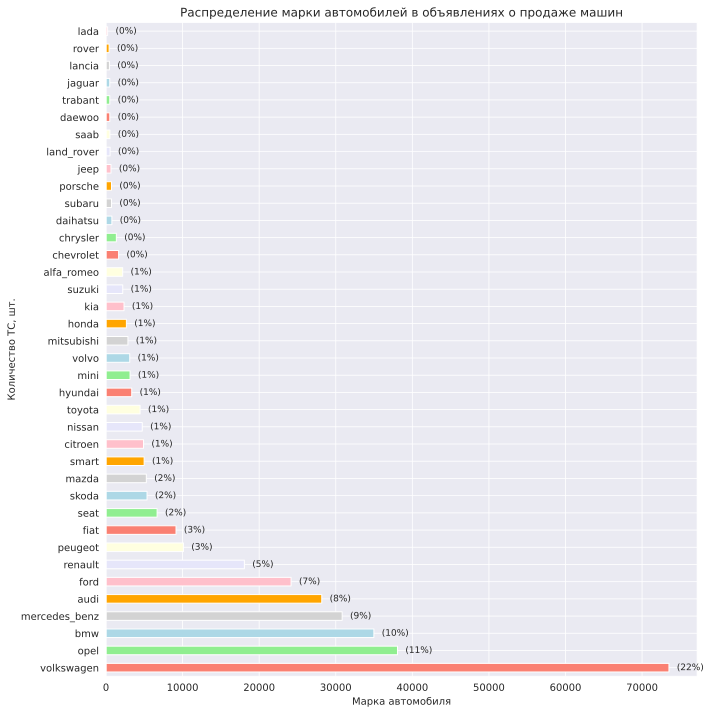

In [132]:
create_barh(df.brand.value_counts(),'Марка автомобиля', 'Количество ТС, шт.',
            'Распределение марки автомобилей в объявлениях о продаже машин', figsize=(10, 10))

ТОП-3 самых популярных бренда Volkswagen, Opel, Mercedes_benz

In [133]:
# выведем уникальные значения признака reg_year
df['registration_year'].describe()

count    334664.000000
mean       2003.923992
std          69.377219
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [134]:
# удалим неправдоподобно низкие значения для построения корректной гистограммы
df_cleaned = df[(df['registration_year'] >= 1940) & (df['registration_year'] <= 2016)]

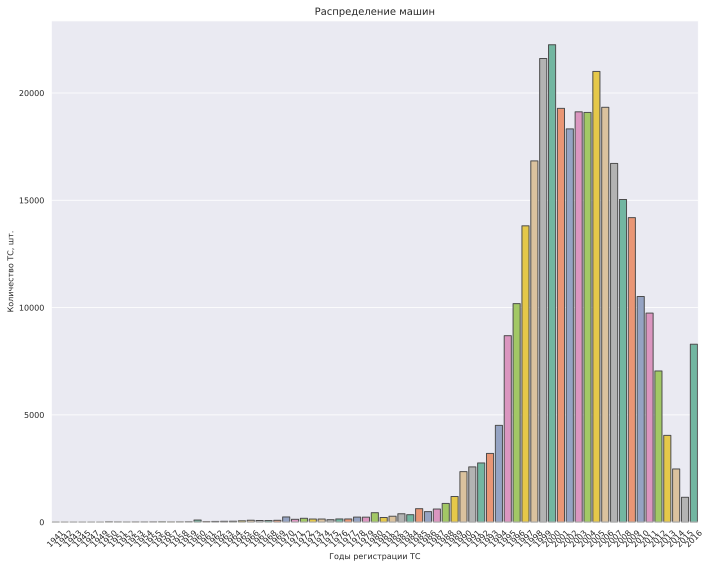

In [135]:
creat_plot_views(df_cleaned.registration_year, 'Годы регистрации ТС', 'Распределение машин', 
                 figsize=(10, 8), rotation=45, title_fontsize=10, label_fontsize=8)

По графику видно, что до 1959 года количество продаваемых автомобилей единицы, значит эти значения нам не нужны для построения модели

In [136]:
# выведем на экран строки с некорректными значениями в годе регистрации ТС
# используем фильтры по дате создания первого автомобиля и текущим годом
df.loc[(df['registration_year'] < 1959) | (df['registration_year'] > 2016)]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
48,7750,NaN,2017,manual,80,golf,100000,petrol,volkswagen,NaN
51,2000,NaN,2017,manual,90,punto,150000,gasoline,fiat,yes
...,...,...,...,...,...,...,...,...,...,...
354140,1000,NaN,2017,manual,101,a4,150000,NaN,audi,NaN
354203,2140,NaN,2018,manual,80,fiesta,150000,NaN,ford,no
354253,1250,NaN,2018,NaN,0,corsa,150000,petrol,opel,NaN
354289,5000,NaN,2017,manual,120,other,150000,NaN,citroen,yes


In [137]:
# удалим строки с некорректными значениями в годе регистрации ТС, так как восстановить их невозможно, 
# а возраст автомобиля влияет на его стоимость
df = df.drop(df[(df['registration_year'] < 1959) | (df['registration_year'] > 2016)].index)

In [138]:
# выведем уникальные значения в категориальных данных
df['vehicle_type'].unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe', 'other'], dtype=object)

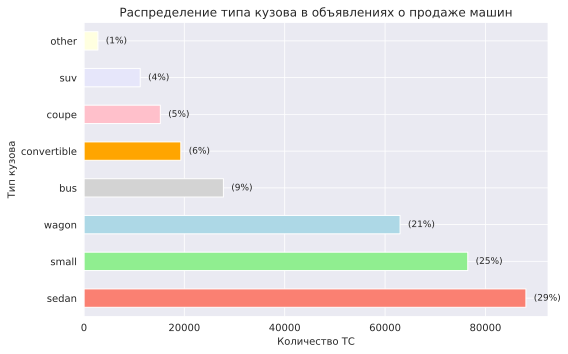

In [139]:
create_barh(df.vehicle_type.value_counts(),'Количество ТС', 'Тип кузова', 
            'Распределение типа кузова в объявлениях о продаже машин', figsize = (8, 5))

In [140]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

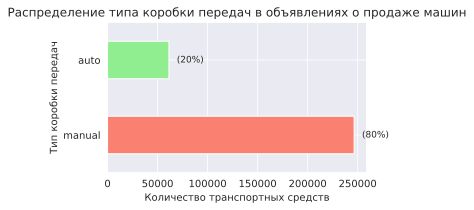

In [141]:
create_barh(df.gearbox.value_counts(),'Количество транспортных средств', 'Тип коробки передач',
            'Распределение типа коробки передач в объявлениях о продаже машин', figsize = (5, 3))

Самый распространенный тип коробки передач 'manual'

In [142]:
# некорректные значения в мощности автомобиля заменим на пропуски
df['power'] = df['power'].astype(float)

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321971 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              321971 non-null  int64  
 1   vehicle_type       303830 non-null  object 
 2   registration_year  321971 non-null  int64  
 3   gearbox            307795 non-null  object 
 4   power              321971 non-null  float64
 5   model              321971 non-null  object 
 6   kilometer          321971 non-null  int64  
 7   fuel_type          300829 non-null  object 
 8   brand              321971 non-null  object 
 9   repaired           265320 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 27.0+ MB


In [144]:
# удалим аномальгные значения для построения графика
df_cl = df[(df['power']>= 40) & (df['power'] <= 500)]

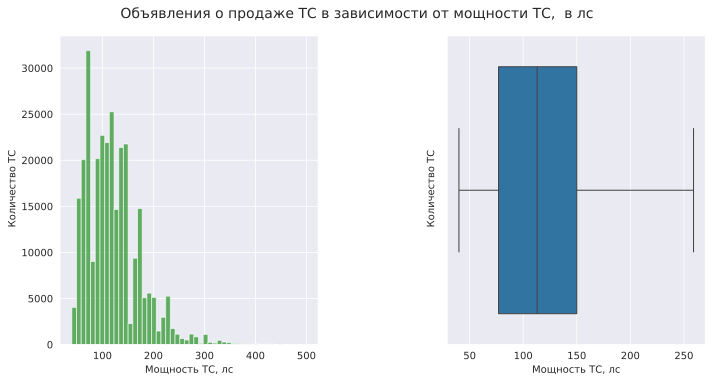

In [145]:
create_plots(df_cl.power, 'Мощность ТС, лс',' Количество ТС',
             'Объявления о продаже ТС в зависимости от мощности ТС,  в лс')

In [146]:
# удалим аномальные значения в признаке power
df = df.drop(df[(df['power'] < 40) | (df['power'] > 500)].index)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289766 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              289766 non-null  int64  
 1   vehicle_type       279630 non-null  object 
 2   registration_year  289766 non-null  int64  
 3   gearbox            284908 non-null  object 
 4   power              289766 non-null  float64
 5   model              289766 non-null  object 
 6   kilometer          289766 non-null  int64  
 7   fuel_type          276104 non-null  object 
 8   brand              289766 non-null  object 
 9   repaired           248934 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 24.3+ MB


In [148]:
df['power']=df['power'].astype(int)

In [149]:
df['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [150]:
# заменим тип топлива gasoline на petrol, так как это один и тот же тип, но с разными названиями в разных странах
df['fuel_type'] = df['fuel_type'].str.replace('gasoline', 'petrol', case=False)

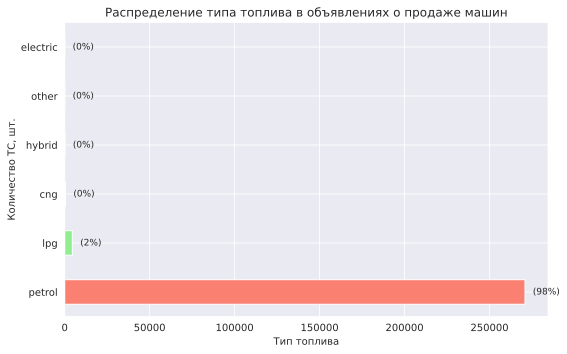

In [151]:
create_barh(df.fuel_type.value_counts(),'Тип топлива', 'Количество ТС, шт.',
            'Распределение типа топлива в объявлениях о продаже машин', figsize = (8, 5))

Самый популярный тип двигателя бензиновый, аномальных значений в признакет нет

In [152]:
df['repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

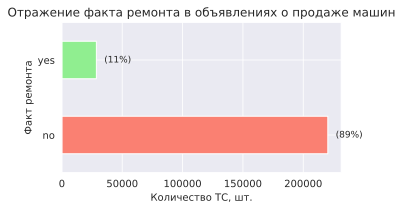

In [153]:
create_barh(df.repaired.value_counts(),'Количество ТС, шт.', 'Факт ремонта',
            'Отражение факта ремонта в объявлениях о продаже машин', figsize = (5, 3))

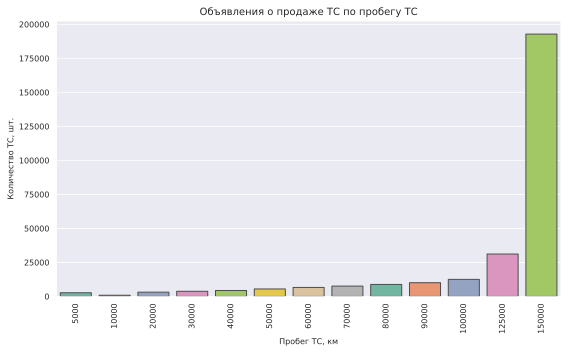

In [154]:
creat_plot_views(df.kilometer, 'Пробег ТС, км',
             'Объявления о продаже ТС по пробегу ТС', figsize = (8, 5))

Больше всего продают автомобилей с пробегом 150 000 км, аномальных значений нет

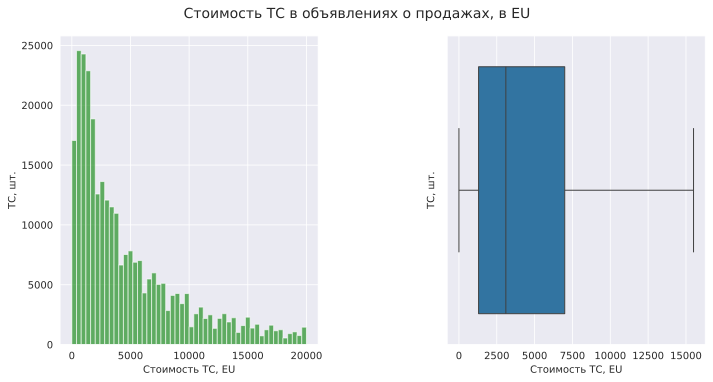

In [155]:
create_plots(df.price, 'Стоимость ТС, EU','ТС, шт.',
             'Стоимость ТС в объявлениях о продажах, в EU')

Принято решение удалить строки с аномальными значениями, так как нет возможности восстановить данные, а заполнять данные медианными значениями в зависимости от других признаков будет влиять на коэффициент корреляции между признаками и, возможно, приведет к ошибкам в модели.

In [158]:
df = df.drop(df[df['price'] < 50].index)

In [159]:
# заменим пропуски на значение unknown
df=df.fillna('unknown')

In [160]:
# посмотрим получившийся датасет
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283195 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              283195 non-null  int64 
 1   vehicle_type       283195 non-null  object
 2   registration_year  283195 non-null  int64 
 3   gearbox            283195 non-null  object
 4   power              283195 non-null  int64 
 5   model              283195 non-null  object
 6   kilometer          283195 non-null  int64 
 7   fuel_type          283195 non-null  object
 8   brand              283195 non-null  object
 9   repaired           283195 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.8+ MB


In [161]:
# построим матрицу корреляции phik
data_types = {'vehicle_type':'categorical',
              'reg_year': 'discrete',
              'gearbox':'categorical',
              'power': 'discrete',
              'model ':'categorical',
              'kilometer ': 'discrete',
              'fuel_type ':'categorical',
              'brand ':'categorical',
              'repaired ':'categorical',
              'price':'interval'}

interval_cols = [col for col, v in data_types.items() if v=='interval' and col in df.columns]

In [162]:
сorrelation_matrix = df.phik_matrix(interval_cols=interval_cols, bins = 5)
display(сorrelation_matrix)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
price,1.000000,0.273917,0.694582,0.225334,0.644834,0.585957,0.368204,0.082950,0.338088,0.225613
vehicle_type,0.273917,1.000000,0.636979,0.372715,0.691781,0.906219,0.193411,0.248785,0.588729,0.316173
registration_year,0.694582,0.636979,1.000000,0.189682,0.664416,0.682131,0.643906,0.260889,0.295194,0.331609
gearbox,0.225334,0.372715,0.189682,1.000000,0.625160,0.633534,0.042045,0.123066,0.522463,0.241404
power,0.644834,0.691781,0.664416,0.625160,1.000000,0.976261,0.362728,0.334983,0.899849,0.272882
model,0.585957,0.906219,0.682131,0.633534,0.976261,1.000000,0.442268,0.329167,0.998034,0.221257
kilometer,0.368204,0.193411,0.643906,0.042045,0.362728,0.442268,1.000000,0.083188,0.251948,0.182945
fuel_type,0.082950,0.248785,0.260889,0.123066,0.334983,0.329167,0.083188,1.000000,0.190726,0.170862
brand,0.338088,0.588729,0.295194,0.522463,0.899849,0.998034,0.251948,0.190726,1.000000,0.129216
repaired,0.225613,0.316173,0.331609,0.241404,0.272882,0.221257,0.182945,0.170862,0.129216,1.000000


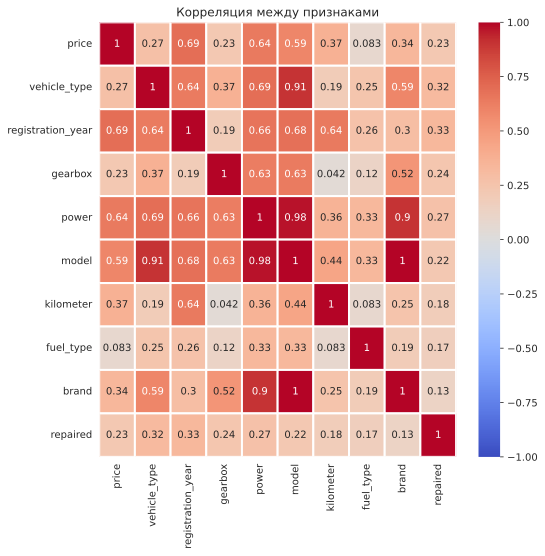

In [163]:
fig = plt.figure(figsize=(8, 8)) 
sns.heatmap(сorrelation_matrix, annot = True, fmt = '.2g', cmap = 'coolwarm', vmin = -1, center = 0, linewidths = 2)
plt.title('Корреляция между признаками')
plt.show()

## Выводы по этапу предобработки и анализу данных
При чтении файла был заменен тип данных на datetime64 в столбцах 'DateCrawled', 'DateCreated', 'LastSeen', в остальных столбцах тип данных соответствует значениям.
Есть пропуски данных в признаках:
- VehicleType
- Gearbox
- Model
- FuelType
- Repaired   
Данных достаточно для анализа.


 В процессе предобработки и анализа данных был создан датасет df для дальнейшей работы с данными, названия столбцов переименованы в соответствии с синтаксисом.  Из датасета df были удалены признаки, не влияющие на ценообразование автомобиля: 'date_crawled', 'reg_month', 'date_created', 'number_of_pictures', 'last_seen', 'postal_code'.   
Дубликаты не были удалены, так как значения оказались различными.       

Аномальные (ниже 40 и свыше 500 л/с) и пропущенные значения в столбце power были удалены, так как значение мощности автомобиля влияет на его цену, заполнение любым другим значением будет влиять на прогноз модели.
Удалены некорректные значения в признаке registration_year (все аномально низкие и аномально высокие значения, которые в данных преобладают в единичном количестве)
Исправлены опечатки в признаке model, удалены пропущенные значения в данном признаке, так как восстановить данные невозможно.    
Пропущенные значения в столбце в признаках vehicle_type, gearbox, fuel_type, repaired были заменены на unknown
Также в датасете были удалены аномально низкие значения цены автомобиля (до 2 EU),     
Общий объем удаленных данных — 19801 строка, 5,6%.

Был создан датасет df_final    
Согласно матрице phik, видна высокая корреляция признаков reg_year, model и power с целевым признаком. Также замечена высокая корреляция между признаками model и brand, отсюда было принято решение удалить признак brand из признаков для обучения модели. 

Общий объем удаленных данных 71174, 20% от всего датасета

## 3. Подготовка данных и обучение модели

In [164]:
RANDOM_STATE = 72
TEST_SIZE = 0.3
X = df.drop(['price', 'brand'], axis= 1)
y= df['price']

#разделим выборки на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state = RANDOM_STATE,
    test_size = TEST_SIZE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((198236, 8), (84959, 8), (198236,), (84959,))

In [165]:
ohe_columns = [
    'fuel_type',     
    'repaired', 
    'gearbox',
    'vehicle_type'
]

ord_columns = ['model']
num_columns = ['kilometer', 'power', 'registration_year'] 

In [166]:
# создание пайплайнов для обработки данных
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])
ord_pipe = Pipeline(
    [ ('ord',  
       OrdinalEncoder(categories=[
      ['golf', 'unknown', 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
       'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba', 'colt',
       'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace',
       'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe',
       'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'c1', 'rio', 'touareg', 'logan', 'spider',
       'cuore', 's_max', 'a2', 'galaxy', 'c3', 'viano', 's_klasse',
       '1_reihe', 'avensis', 'roomster', 'sl', 'kaefer', 'santa',
       'cooper', 'leon', '4_reihe', 'a5', '500', 'laguna', 'ptcruiser',
       'clk', 'primera', 'x_reihe', 'exeo', '159', 'transit', 'juke',
       'qashqai', 'carisma', 'accord', 'corolla', 'lanos', 'phaeton',
       'verso', 'swift', 'rav', 'picanto', 'boxster', 'kalos', 'superb',
       'stilo', 'alhambra', 'mx_reihe', 'roadster', 'ypsilon', 'cayenne',
       'galant', 'justy', '90', 'sirion', 'crossfire', 'agila', 'duster',
       'cr_reihe', 'v50', 'c_reihe', 'v_klasse', 'm_klasse', 'yaris',
       'c5', 'aygo', 'cc', 'carnival', 'fusion', '911', 'bora', 'forfour',
       'cl', 'tigra', '300c', 'spark', 'v70', 'kuga', 'x_type', 'ducato',
       's_type', 'x_trail', 'toledo', 'altea', 'voyager', 'calibra',
       'bravo', 'antara', 'tucson', 'citigo', 'jimny', 'wrangler',
       'lybra', 'q7', 'lancer', 'captiva', 'c2', 'discovery',
       'freelander', 'sandero', 'note', '900', 'cherokee', 'clubman',
       'samara', 'defender', '601', 'cx_reihe', 'legacy', 'pajero',
       'auris', 'niva', 's60', 'm_reihe', 'nubira', 'vivaro', 'g_klasse',
       'lodgy', '850', 'range_rover', 'q3', 'serie_2', 'glk', 'charade',
       'croma', 'outlander', 'doblo', 'musa', 'move', '9000', 'v60',
       '145', 'aveo', '200', 'b_max', 'range_rover_sport', 'terios', 'q5',
       'range_rover_evoque', 'materia', 'delta', 'gl', 'kalina', 'amarok',
       'elefantino', 'i3', 'kappa', 'serie_3', 'serie_1']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [167]:
# объединение пайплайнов в один ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns) 
    ], 
    remainder='passthrough'
)


In [168]:
def train_single_model(model, params, model_name, results_df):

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Используем RandomizedSearchCV для нахождения лучших гиперпараметров
    rz_search = RandomizedSearchCV(
    pipeline, 
    params, 
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state= RANDOM_STATE,
    error_score='raise'
)

    # Запускаем обучение и измеряем время
    start_time_fit = time.time()
    rz_search.fit(X_train, y_train)
    end_time_fit = time.time()

    # Оценка модели и измерение времени обучения
    start_time_pr = time.time()
    y_pred = rz_search.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    end_time_pr = time.time()
    
    # Собираем результаты в виде словаря
    best_params = rz_search.best_params_
    result = {
        'model_name': model_name,
        'best_params': best_params,
        'rmse': rmse,
        'fit_time': end_time_fit - start_time_fit,
        'predict_time': end_time_pr - start_time_pr
    }
    results_df = results_df.append(result, ignore_index=True)

    # Выводим результаты
    print("Лучшие гиперпараметры:", rz_search.best_params_)
    print("RMSE на валидационных данных:", rmse)
    print("Время обучения модели:", end_time_fit - start_time_fit, "секунд")
    print("Время предсказания модели:", end_time_pr - start_time_pr, "секунд")

    return results_df

In [169]:
results_df = pd.DataFrame(columns=['model_name', 'rmse', 'fit_time', 'predict_time'])

Подберем параметры для DecisionTreeRegressor.      
Установим глубину от 5 до 10, так как строк в датасете около 300 000 и очень больше количество значений в признаке model, это обеспечит достаточно глубокое дерево для захвата зависимости, но недостаточно глубокое, чтобы переобучиться на шуме.
Количество листов от 3 до 20, чтобы избежать количество образцов, в которых содержится слишком мало данных, и специфичных результатов
Количество делений от 5 до 10, чтобы избежать разделений на узлах, содержащих слишком мало наблюдений, что также может способствовать уменьшению переобучения.

In [170]:
model = DecisionTreeRegressor(random_state=42)
params =  {
        'model__max_depth': range(5, 10),
        'model__min_samples_leaf': range(3, 20),
        'model__min_samples_split': range(4, 10)}

results_df = train_single_model(model, params, DecisionTreeRegressor, results_df)

Лучшие гиперпараметры: {'model__min_samples_split': 6, 'model__min_samples_leaf': 10, 'model__max_depth': 9}
RMSE на валидационных данных: 2037.817794358596
Время обучения модели: 15.724682092666626 секунд
Время предсказания модели: 0.11937379837036133 секунд


Подберем параметры для LGBMRegressor      
Установим model__max_depth в диапазоне от 4 до 10, потому что ограничение глубины дерева помогает контролировать сложность модели и уменьшить риск переобучения
model__n_estimators, чтобы не увеличивать время обучения
model__num_leaves от 20 до 30, так как чем больше количество листьев, тем больше информации может хранить модель о данных, что позволяет улучшить ее производительность

In [171]:
model = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
params =  {
        'model__max_depth': range(4, 10),
        'model__n_estimators': range(50, 100),
        'model__num_leaves': range(20, 30)}

results_df = train_single_model(model, params, LGBMRegressor, results_df)

Лучшие гиперпараметры: {'model__num_leaves': 28, 'model__n_estimators': 98, 'model__max_depth': 6}
RMSE на валидационных данных: 1759.3470902298957
Время обучения модели: 193.58309078216553 секунд
Время предсказания модели: 0.8011074066162109 секунд


Подберем параметры для LogisticRegression     
model__C, включающий малые значения, которые могут вести себя более предсказуемо
L1-регуляризация может помочь в отборе признаков и делает коэффициенты более разреженными.
solver='saga' дял большого количества данных

In [172]:
model: [LogisticRegression(random_state=RANDOM_STATE, solver='saga', penalty='l1')]
params = {
    'model__C': [0.001, 0.01, 0.1, 1, 10]}

results_df = train_single_model(model, params, LogisticRegression, results_df)

[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: C
Лучшие гиперпараметры: {'model__C': 0.001}
RMSE на валидационных данных: 1719.1913131367398
Время обучения модели: 80.69319725036621 секунд
Время предсказания модели: 0.8174417018890381 секунд


In [173]:
display(results_df)

,model_name,rmse,fit_time,predict_time,best_params
0,<class 'sklearn.tree._classes.DecisionTreeRegr...,2037.817794,15.724682,0.119374,"{'model__min_samples_split': 6, 'model__min_sa..."
1,<class 'lightgbm.sklearn.LGBMRegressor'>,1759.347090,193.583091,0.801107,"{'model__num_leaves': 28, 'model__n_estimators..."
2,<class 'sklearn.linear_model._logistic.Logisti...,1719.191313,80.693197,0.817442,{'model__C': 0.001}


### Выводы по этапу подготовки данных и обучения модели
Данные были разделены на выборки в размере 70% тренировочная и 30% валидационная.
Для кодирования данных были использованы следующие кодировщики:       
OneHotEncoder для категориальных признаков: 'repaired', 'gearbox', 'vehicle_type', 'fuel_type'.    
OrdinalEncoder для категориального признака model.     
MinMaxScaler для количественных данных.

По результатам обучения самый высокий результат по времени обучения показала модель DecisionTreeRegression, и она же показала самый высокий результат по скорости предсказания.
При условии выполнения значения точности предсказаний выше целевого параметра 2500, можно рекомендовать данную модель для выполнения задач заказчика.

## 4. Проверка качества модели

In [174]:
best_model = DecisionTreeRegressor(
    min_samples_split=6,
    min_samples_leaf=10,
    max_depth=9)

pipeline = make_pipeline(preprocessor, best_model)

In [175]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Оценка качества
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Коэффициент детерминации (R^2):", rmse)

Коэффициент детерминации (R^2): 2037.817794358596


In [176]:
# Оценка стабильности с помощью кросс-валидации
cv_scores = cross_val_score(pipeline, X, y, cv=3, error_score='raise')
print("Средняя точность кросс-валидации:", cv_scores.mean())
print("Стандартное отклонение:", cv_scores.std())

Средняя точность кросс-валидации: 0.8051930090329243
Стандартное отклонение: 0.001679862212116333


## Общие выводы по проекту:


##### При чтении файла был заменен тип данных на datetime64 в столбцах 'DateCrawled', 'DateCreated', 'LastSeen', в остальных столбцах тип данных соответствует значениям.
Есть пропуски данных в признаках:
- VehicleType
- Gearbox
- Model
- FuelType
- Repaired   
Данных достаточно для анализа.


 В процессе предобработки и анализа данных был создан датасет df для дальнейшей работы с данными, названия столбцов переименованы в соответствии с синтаксисом.  Из датасета df были удалены признаки, не влияющие на ценообразование автомобиля: 'date_crawled', 'reg_month', 'date_created', 'number_of_pictures', 'last_seen', 'postal_code'.   
Дубликаты не были удалены, так как значения оказались различными.       

Аномальные (ниже 40 и свыше 500 л/с) и пропущенные значения в столбце power были удалены, так как значение мощности автомобиля влияет на его цену, заполнение любым другим значением будет влиять на прогноз модели.
Удалены некорректные значения в признаке registration_year (все аномально низкие и аномально высокие значения, которые в данных преобладают в единичном количестве)
Исправлены опечатки в признаке model, удалены пропущенные значения в данном признаке, так как восстановить данные невозможно.    
Пропущенные значения в столбце в признаках vehicle_type, gearbox, fuel_type, repaired были заменены на unknown
Также в датасете были удалены аномально низкие значения цены автомобиля (до 2 EU),     
Общий объем удаленных данных — 19801 строка, 5,6%.

Был создан датасет df_final    
Согласно матрице phik, видна высокая корреляция признаков reg_year, model и power с целевым признаком. Также замечена высокая корреляция между признаками model и brand, отсюда было принято решение удалить признак brand из признаков для обучения модели. 

Общий объем удаленных данных 71174, 20% от всего датасета


Данные были разделены на выборки в размере 70% тренировочная и 30% валидационная.
Для кодирования данных были использованы следующие кодировщики:        
- OneHotEncoder для категориальных признаков: 'repaired', 'gearbox', 'vehicle_type', 'fuel_type',
- OrdinalEncoder для категориального признака model,
- MinMaxScaler для количественных данных.

По результатам обучения самый высокий результат по времени обучения показала модель DecisionTreeRegression, и она же показала самый высокий результат по скорости предсказания (Время обучения модели: 15.72 секунды, время предсказания модели: 0.11 секунды.
При условии выполнения значения точности предсказаний выше целевого параметра 2500, можно рекомендовать данную модель для выполнения задач заказчика (RMSE : 2037.81). 
Второй результат по скорости обучения модели показала LogisticRegression: RMSE : 1719.19, время обучения модели: 80.69 секунд, время предсказания модели: 0.82 секунд.
Самую низкую скорость предсказания показала модель LGBMRegressor: RMSE на валидационных данных: 1759.35, но время обучения намного выше: время обучения модели: 193.58 секунды, время предсказания модели: 0.8 секунд


При анализе стабильности модели, показатель средней точности кросс-валидации 0.81 говорит о том, что в среднем эта модель правильно классифицирует примерно 81% экземпляров  данных, что для целей настоящего исследования приемлимо.
Низкое стандартное отклонение говорит о том, что модель ведет себя последовательно и результаты в различных вариантах разделения данных достаточно стабильны и надежны.